In [160]:
import pandas as pd
import matplotlib.pyplot as plt

In [161]:
data = pd.read_csv('data.csv')

In [162]:
#Encoding Signal 0-none 1-buy 2-sell
signal = list(data.signal.unique())
print(signal)
for i in range(len(signal)):
    data.signal.replace({signal[i]:i},inplace=True)

['none', 'buy', 'sell']


<Axes: >

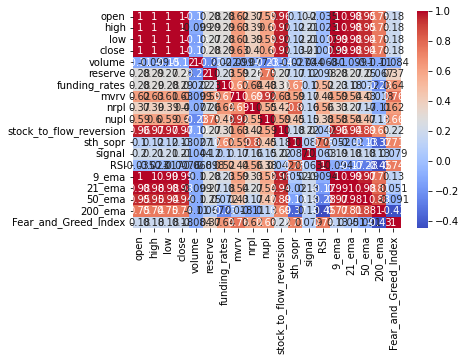

In [163]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr,annot=True,cbar=True , cmap='coolwarm')

In [164]:
datetime = data[['datetime']]
data = data.drop(['datetime'], axis = 1)

In [165]:
# Check for negative values in each column
columns_with_negatives = data.columns[(data < 0).any()]

# Print columns with negative values
print("Columns with negative values:")
print(columns_with_negatives)

Columns with negative values:
Index(['funding_rates', 'nrpl', 'nupl'], dtype='object')


In [166]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler()

# Fit and transform selected columns
data[columns_with_negatives] = scaler.fit_transform(data[columns_with_negatives])

# Check the scaled columns
print(data[columns_with_negatives])

     funding_rates      nrpl      nupl
0         0.465514  0.422856  0.635702
1         0.457869  0.423253  0.637455
2         0.446281  0.423971  0.638958
3         0.459889  0.425239  0.641546
4         0.468883  0.423918  0.637428
..             ...       ...       ...
930       0.468153  0.459271  0.452341
931       0.495878  0.439719  0.443978
932       0.477149  0.433091  0.441783
933       0.457788  0.437090  0.437959
934       0.445436  0.423542  0.424615

[935 rows x 3 columns]


In [167]:
# Recheck for negative values
columns_with_negatives = data.columns[(data < 0).any()]
print("Columns with negative values:")
print(columns_with_negatives)

Columns with negative values:
Index([], dtype='object')


In [168]:
#adding signal to the end of the dataframe
target = data[['signal']]
data = data.drop(['signal'], axis = 1)
data['signal']=target
print(data)

         open      high       low     close        volume       reserve  \
0     9190.80   9216.02   9005.00   9130.11   8765.698589  2.889262e+06   
1     9130.93   9182.99   9054.99   9154.29   6423.747162  2.889943e+06   
2     9154.29   9210.00   9122.65   9175.85   4121.626974  2.890642e+06   
3     9175.83   9245.03   9105.37   9212.87   3520.072476  2.892067e+06   
4     9214.01   9223.51   9131.00   9161.05   5815.330842  2.891858e+06   
..        ...       ...       ...       ...           ...           ...   
930  23127.15  23813.57  22760.00  23735.97  20292.224170  2.228658e+06   
931  23735.97  24262.18  23367.87  23493.84  16368.921383  2.225632e+06   
932  23497.29  23720.00  23208.01  23433.54  14215.668430  2.221115e+06   
933  23433.47  23589.67  23257.71  23328.87   3567.130075  2.219863e+06   
934  23329.47  23433.20  22758.01  22936.34   6536.140584  2.222216e+06   

     funding_rates      mvrv      nrpl      nupl  stock_to_flow_reversion  \
0         0.465514  1.

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [170]:
#splitting data
input_data = data.iloc[: , :19]
X_train, X_test, y_train, y_test = train_test_split(input_data, data['signal'], test_size=.2, random_state=42)

In [171]:
#Independent Model creation
model_signal = RandomForestClassifier(n_estimators=100, random_state=42)
model_signal.fit(X_train, y_train)

    # Make predictions
predicted_signal = model_signal.predict(X_test)

In [172]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(predicted_signal, y_test)
print(acc)

1.0


In [173]:
# import pickle 
  
# # Save the trained model as a pickle string. 
# saved_model = pickle.dumps(model_signal) 
  
# # Load the pickled model 
# signal = pickle.loads(saved_model) 

In [174]:
from sklearn import metrics
print ('Classification Report:\n', metrics.classification_report(y_test, predicted_signal))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        19

    accuracy                           1.00       187
   macro avg       1.00      1.00      1.00       187
weighted avg       1.00      1.00      1.00       187



In [175]:
report_dict = pd.DataFrame(metrics.classification_report(y_test, predicted_signal, output_dict=True))
report_dict

,0,1,2,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
support,148.0,20.0,19.0,1.0,187.0,187.0


In [176]:
#strategy backtesting
X=data.iloc[: , :19]
predicted_signal = model_signal.predict(X)
data['datetime']=datetime
data['predicted_signal']=predicted_signal

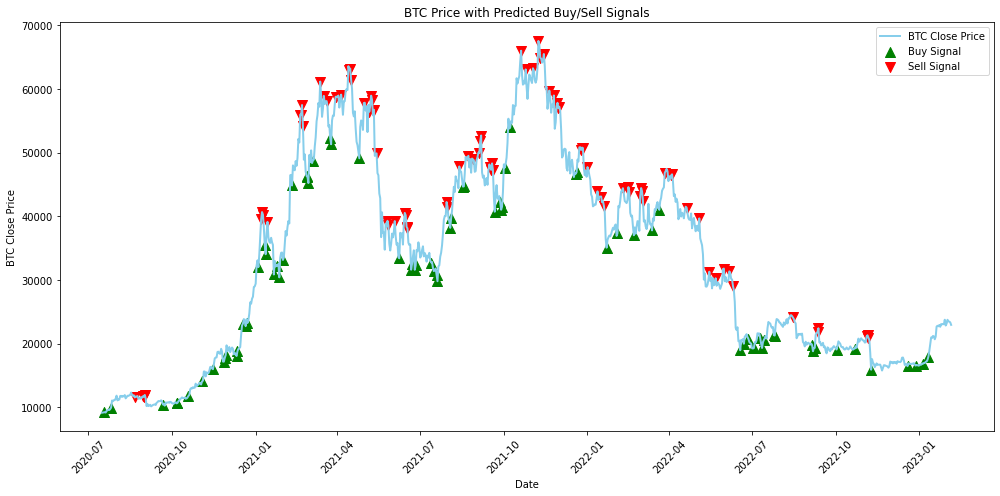

In [177]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime is in the correct format
data['datetime'] = pd.to_datetime(data['datetime'])

plt.figure(figsize=(14, 7))
plt.plot(data['datetime'], data['close'], label='BTC Close Price', color='skyblue', linewidth=2)

# Adjust the conditions to match the labels
# Highlight buy signals
buy_signals = data[data['predicted_signal'] == 1]  # Assuming 0 represents 'buy'
plt.scatter(buy_signals['datetime'], buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1, s=100)

# Highlight sell signals
sell_signals = data[data['predicted_signal'] == 2]  # Assuming 1 represents 'sell'
plt.scatter(sell_signals['datetime'], sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()